In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

C:\Users\daeky\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
store = pd.read_csv('../input/rossmann-store-sales/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
train = pd.read_csv('../input/rossmann-store-sales/train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
train['Sales'] = train['Sales'] * 1.0

In [5]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
# Summing sales on per week basis
train_arima = train.resample("W").mean()
train_arima = train_arima[["Sales"]]

In [7]:
train_arima

,Sales
Date,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960
...,...
2015-07-05,7135.231390
2015-07-12,5303.175144
2015-07-19,6663.474568


In [8]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('Error')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807691526
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522796892
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267332
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857757
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107370084
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943406254
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868304977186
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135674
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259657187
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617136074
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.9086106464392
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089751924
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842520264
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.5804531931

In [9]:
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.076      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


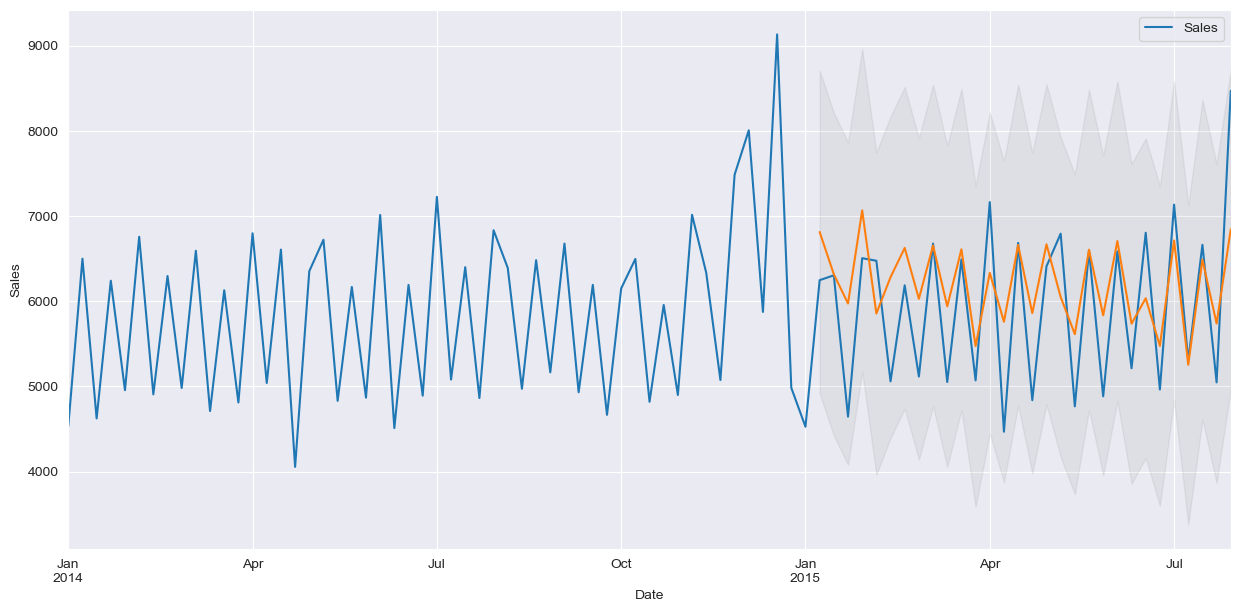

Root Mean Squared Error:  739.0611579862269


In [10]:
pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

## Prophet

In [11]:
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [12]:
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,5,5263.0,555,1,1,0,1
1,2015-07-31,2,5,6064.0,625,1,1,0,1
2,2015-07-31,3,5,8314.0,821,1,1,0,1
3,2015-07-31,4,5,13995.0,1498,1,1,0,1
4,2015-07-31,5,5,4822.0,559,1,1,0,1


In [13]:
ts_week_prophet = train_prophet.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday
ds,,,,,,,
2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533
2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560
2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0
2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0
2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128


### Baseline Model

In [21]:
ts_week_prophet_train = ts_week_prophet[['y']].reset_index()

In [23]:
# Fitting data to Prophet model
prophet_1 = Prophet()
prophet_1.fit(ts_week_prophet_train)

future = prophet_1.make_future_dataframe(periods = 52, freq = "W")
forecast_1 = prophet_1.predict(future)

forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.445995e+07,3.536120e+07,5.333851e+07
183,2016-07-10,4.410757e+07,3.516146e+07,5.417950e+07
184,2016-07-17,4.435103e+07,3.523575e+07,5.334706e+07
185,2016-07-24,4.423847e+07,3.459560e+07,5.415933e+07
186,2016-07-31,4.344693e+07,3.411881e+07,5.261379e+07


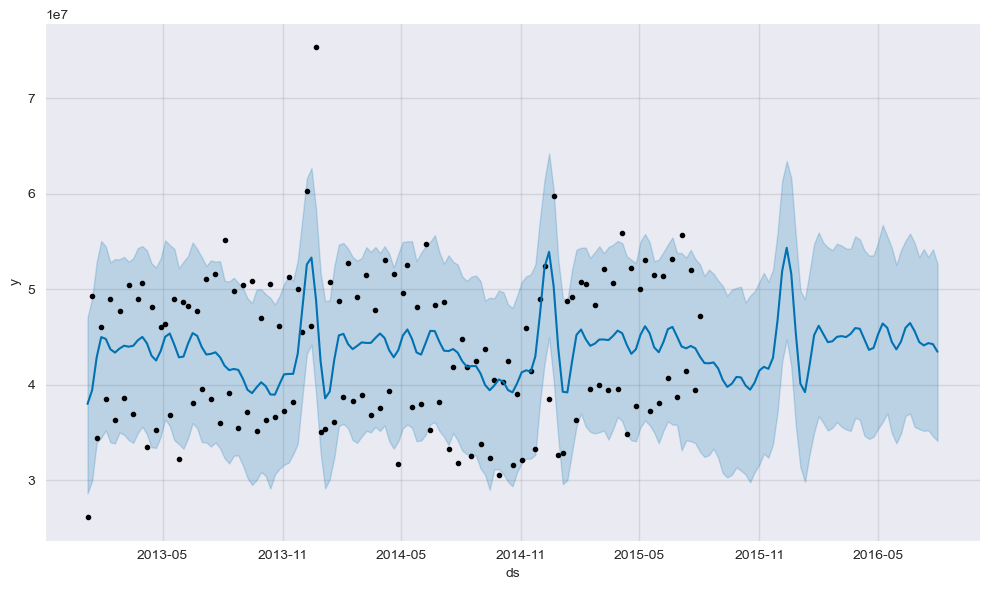

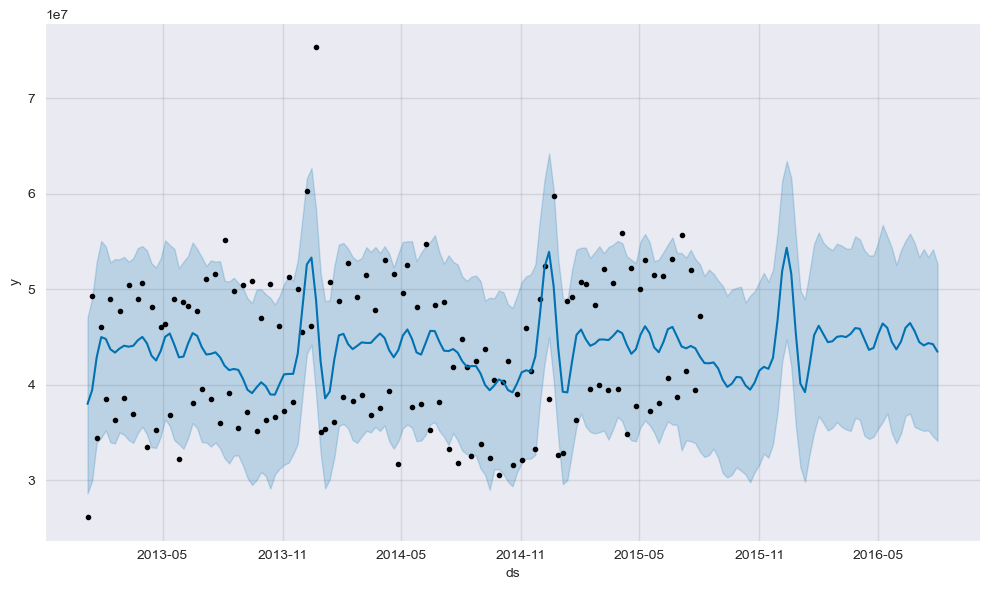

In [25]:
prophet_1.plot(forecast_1)

In [26]:
metric_prophet_1 = forecast_1.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)
rms_prophet_1

53782478490548.46

### Hypertuning Prophet model

In [27]:
train_prophet["StateHoliday_cat"] = train_prophet["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})

In [28]:
train_prophet = train_prophet[['ds', 'y', 'SchoolHoliday', 'StateHoliday_cat']]
train_prophet.head()

,ds,y,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-31,6064.0,1,0
2,2015-07-31,8314.0,1,0
3,2015-07-31,13995.0,1,0
4,2015-07-31,4822.0,1,0


In [29]:
# Modelling holidays - creating holidays dataframe
state_dates = train_prophet[(train_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = train_prophet[(train_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday",  "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday", "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [30]:
# Dropping holiday columns because not needed any more
train_prophet_clean = train_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [31]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [32]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [33]:
# Fitting data to Prophet model
prophet_2 = Prophet(holidays = holidays, interval_width = 0.95, growth='linear', yearly_seasonality = True)
prophet_2.fit(ts_week_prophet_train)
print("done")

future_2 = prophet_2.make_future_dataframe(periods = 52, freq = "W")
forecast_2 = prophet_2.predict(future)

forecast_2[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

10:53:08 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1] done processing


done


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.414504e+07,2.975506e+07,5.773333e+07
183,2016-07-10,4.383961e+07,2.990737e+07,5.831864e+07
184,2016-07-17,4.410866e+07,2.827823e+07,5.874914e+07
185,2016-07-24,4.412181e+07,2.927225e+07,5.829012e+07
186,2016-07-31,4.352344e+07,3.005284e+07,5.722340e+07


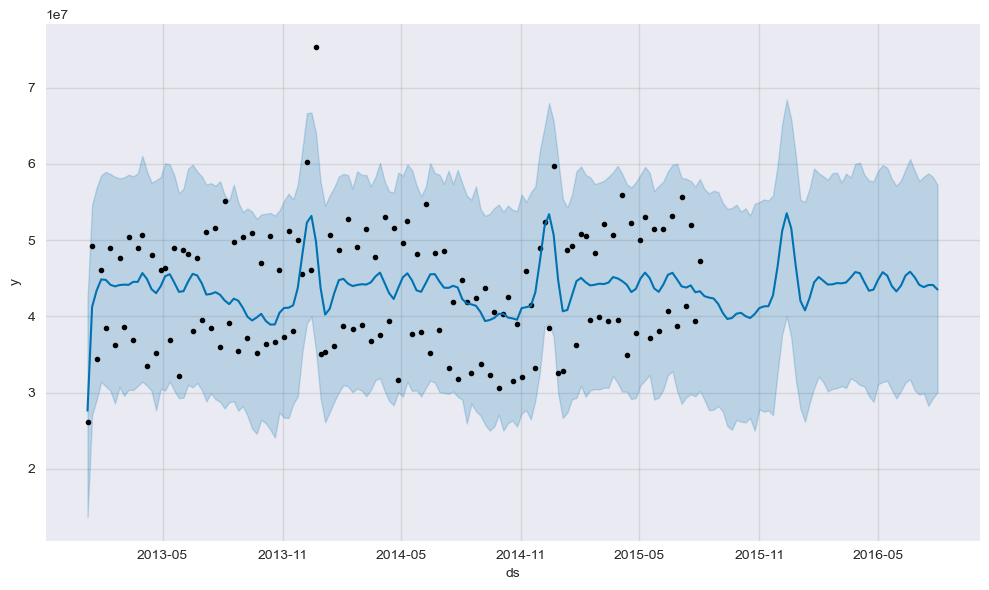

In [35]:
prophet_2.plot(forecast_2);

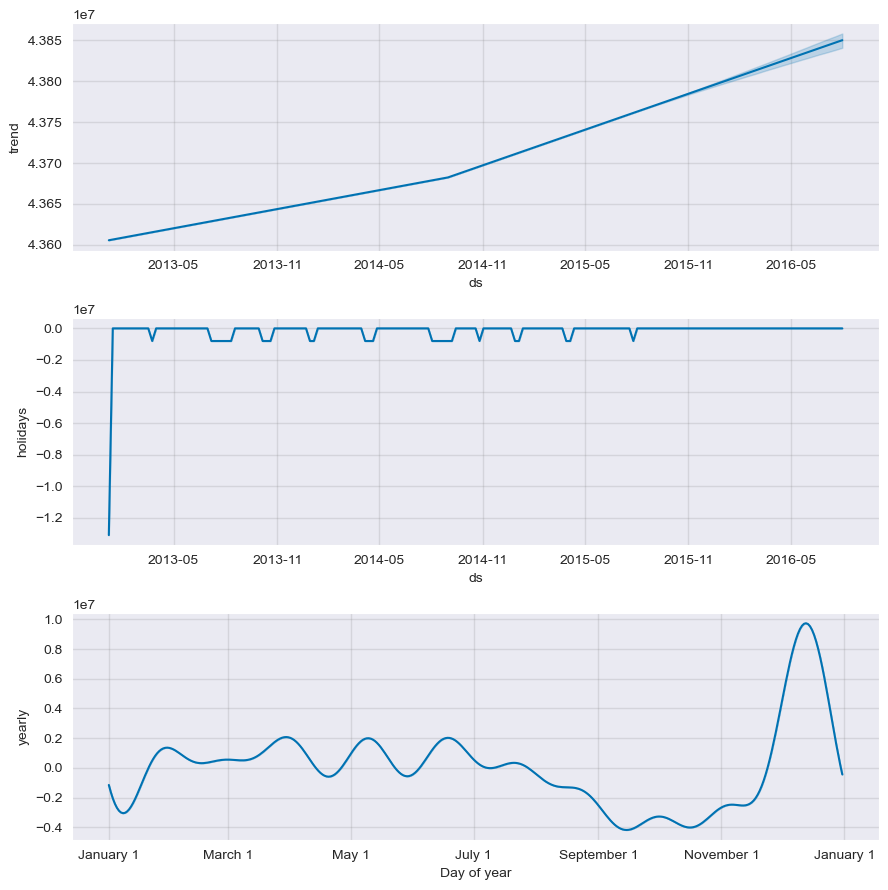

In [37]:
prophet_2.plot_components(forecast_2);

In [48]:
# Checking the RMSE of Prophet model
metric_prophet_2 = forecast_2.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_2.dropna(inplace=True)
rms_prophet_2 = mean_squared_error(metric_prophet_2.y, metric_prophet_2.yhat)
rms_prophet_2 ** (1/2)

7244188.835922065

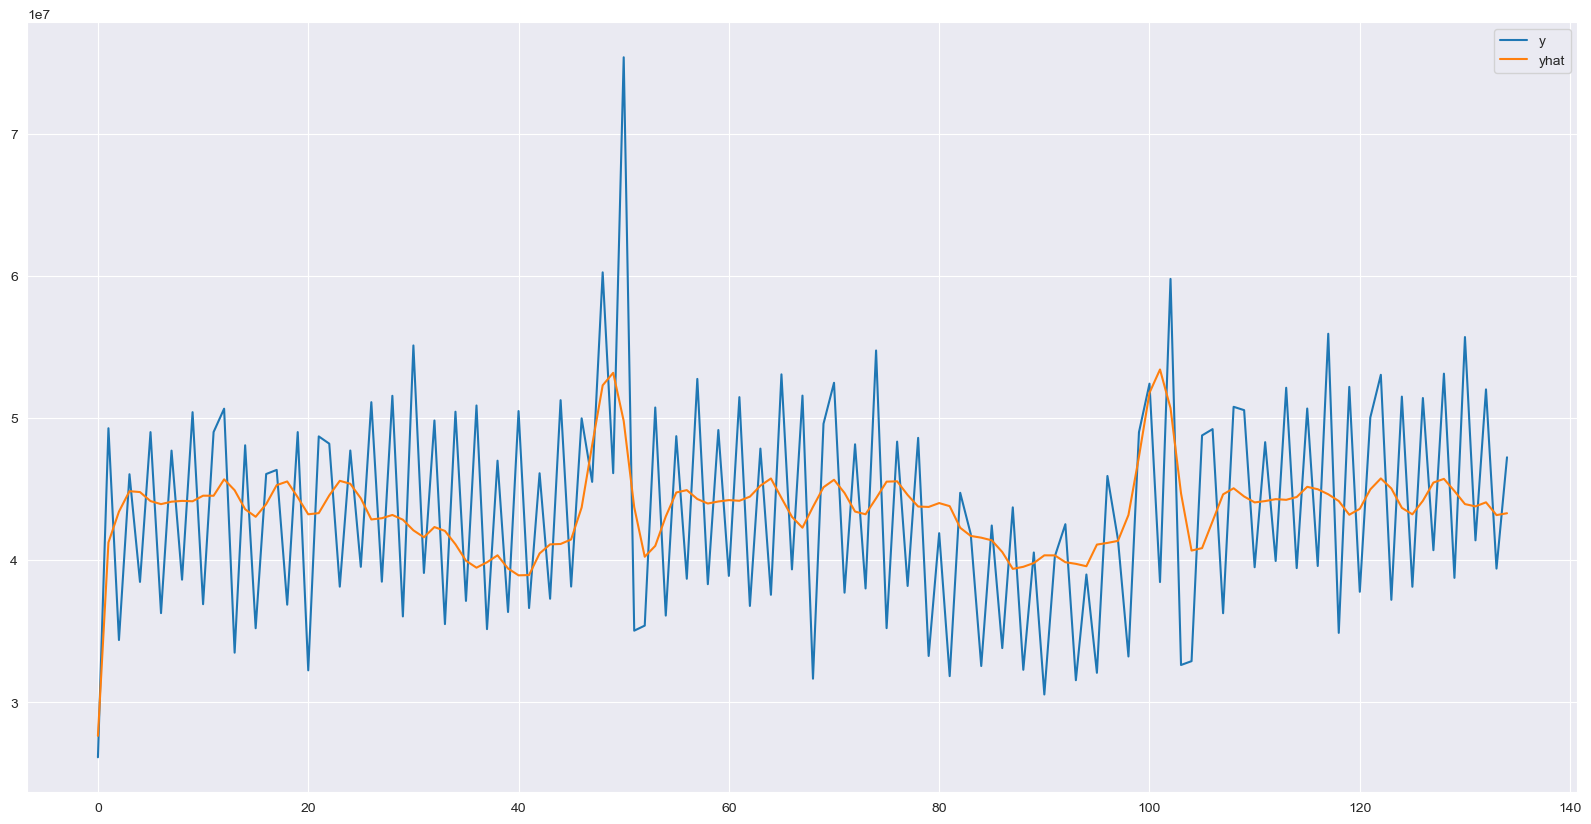

In [39]:
plt.figsize=(10,20)
metric_prophet_2["y"].plot(figsize=(20,10))
metric_prophet_2["yhat"].plot()
plt.legend()
plt.show()

## XGBoost

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data


## Start of main script

print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("../input/rossmann-store-sales/train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("../input/rossmann-store-sales/test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("../input/rossmann-store-sales/store.csv")

print("Assume store open, if not provided")
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero. Simplifies calculation of rmspe")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
build_features(features, train)
build_features([], test)
print(features)

print('training data processed')

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 300

print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero. Simplifies calculation of rmspe
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed
Train a XGBoost model
[11:10:52] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passe

In [55]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1.0,3,...,0.0,,2015,7,31,31,82.0,0.0,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1.0,3,...,0.0,,2015,7,30,31,82.0,0.0,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1.0,3,...,0.0,,2015,7,29,31,82.0,0.0,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1.0,3,...,0.0,,2015,7,28,31,82.0,0.0,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1.0,3,...,0.0,,2015,7,27,31,82.0,0.0,Jul,0
5,1,5,2015-07-25,4364,500,1,0,0,0.0,3,...,0.0,,2015,7,25,30,82.0,0.0,Jul,0
6,1,4,2015-07-24,3706,459,1,0,0,0.0,3,...,0.0,,2015,7,24,30,82.0,0.0,Jul,0
7,1,3,2015-07-23,3769,503,1,0,0,0.0,3,...,0.0,,2015,7,23,30,82.0,0.0,Jul,0
8,1,2,2015-07-22,3464,463,1,0,0,0.0,3,...,0.0,,2015,7,22,30,82.0,0.0,Jul,0
9,1,1,2015-07-21,3558,469,1,0,0,0.0,3,...,0.0,,2015,7,21,30,82.0,0.0,Jul,0


In [56]:
train.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
844328,292,5,2013-01-12,3035,373,1,0,0,0.0,1,...,0.0,,2013,1,12,2,43.0,0.0,Jan,0
844329,292,4,2013-01-11,6316,756,1,1,0,0.0,1,...,0.0,,2013,1,11,2,43.0,0.0,Jan,0
844330,292,3,2013-01-10,6173,747,1,1,0,0.0,1,...,0.0,,2013,1,10,2,43.0,0.0,Jan,0
844331,292,2,2013-01-09,6436,765,1,1,0,0.0,1,...,0.0,,2013,1,9,2,43.0,0.0,Jan,0
844332,292,1,2013-01-08,6859,792,1,1,0,0.0,1,...,0.0,,2013,1,8,2,43.0,0.0,Jan,0
844333,292,0,2013-01-07,9291,1002,1,1,0,0.0,1,...,0.0,,2013,1,7,2,43.0,0.0,Jan,0
844334,292,5,2013-01-05,2748,340,1,0,0,0.0,1,...,0.0,,2013,1,5,1,43.0,0.0,Jan,0
844335,292,4,2013-01-04,4202,560,1,0,0,1.0,1,...,0.0,,2013,1,4,1,43.0,0.0,Jan,0
844336,292,3,2013-01-03,4580,662,1,0,0,1.0,1,...,0.0,,2013,1,3,1,43.0,0.0,Jan,0
844337,292,2,2013-01-02,5076,672,1,0,0,1.0,1,...,0.0,,2013,1,2,1,43.0,0.0,Jan,0


In [59]:
train.groupby('Store').count()

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Store,,,,,,,,,,,,,,,,,,,,,
1,781,781,781,781,781,781,781,781,781,781,...,781,781,781,781,781,781,781,781,781,781
2,784,784,784,784,784,784,784,784,784,784,...,784,784,784,784,784,784,784,784,784,784
3,779,779,779,779,779,779,779,779,779,779,...,779,779,779,779,779,779,779,779,779,779
4,784,784,784,784,784,784,784,784,784,784,...,784,784,784,784,784,784,784,784,784,784
5,779,779,779,779,779,779,779,779,779,779,...,779,779,779,779,779,779,779,779,779,779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,779,779,779,779,779,779,779,779,779,779,...,779,779,779,779,779,779,779,779,779,779
1112,779,779,779,779,779,779,779,779,779,779,...,779,779,779,779,779,779,779,779,779,779
1113,784,784,784,784,784,784,784,784,784,784,...,784,784,784,784,784,784,784,784,784,784
